In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
parameter_values = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Mohtat2020)
param = pybamm.LithiumIonParameters()
Cn = parameter_values.evaluate(param.C_n_init)
Cp = parameter_values.evaluate(param.C_p_init)
n_Li_init = parameter_values.evaluate(param.n_Li_particles_init)
c_n_max = parameter_values.evaluate(param.c_n_max)
c_p_max = parameter_values.evaluate(param.c_p_max)
Cn

5.973262521249683

## Initialize model at full charge to 4.1V

In [97]:
parameter_values = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Chen2020)
parameter_values.update({
    "SEI kinetic rate constant [m.s-1]": 1e-15,
    "SEI resistivity [Ohm.m]": 0,
})
spm = pybamm.lithium_ion.SPM({"SEI": "ec reaction limited"})

In [98]:
esoh_model = pybamm.lithium_ion.ElectrodeSOH()
esoh_sim = pybamm.Simulation(esoh_model, parameter_values=parameter_values)
param = spm.param

Vmin = 2.5
Vmax = 4.2
Cn = parameter_values.evaluate(param.C_n_init)
Cp = parameter_values.evaluate(param.C_p_init)
n_Li_init = parameter_values.evaluate(param.n_Li_particles_init)
c_n_max = parameter_values.evaluate(param.c_n_max)
c_p_max = parameter_values.evaluate(param.c_p_max)

esoh_sol = esoh_sim.solve(
    [0],
    inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li_init},
)
print(esoh_sol["x_100"].data[0])
print(esoh_sol["y_100"].data[0])

0.904538880886973
0.26790222708570915


## One cycle

In [99]:
parameter_values.update(
    {
        "Initial concentration in negative electrode [mol.m-3]": esoh_sol["x_100"].data[0] * c_n_max,
        "Initial concentration in positive electrode [mol.m-3]": esoh_sol["y_100"].data[0] * c_p_max,
    }
)
experiment = pybamm.Experiment([
    (f"Discharge at 1C until {Vmin}V",
     "Rest for 1 hour",
     f"Charge at 1C until {Vmax}V", 
     f"Hold at {Vmax}V until C/50")
])
sim = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values)
spm_sol = sim.solve()

2021-03-02 16:58:07,802 - [NOTICE] simulation.solve(693): Cycle 1/1 (21.710 ms elapsed) --------------------
2021-03-02 16:58:07,803 - [NOTICE] simulation.solve(723): Cycle 1/1, step 1/4: Discharge at 1C until 2.5V
2021-03-02 16:58:08,005 - [NOTICE] simulation.solve(723): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-02 16:58:08,178 - [NOTICE] simulation.solve(723): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-02 16:58:08,368 - [NOTICE] simulation.solve(723): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-03-02 16:58:08,783 - [NOTICE] simulation.solve(784): Finish experiment simulation, took 1.002 s


In [100]:
spm_sol.plot(["Terminal voltage [V]"])

interactive(children=(FloatSlider(value=0.0, description='t', max=3.6147638074320043, step=0.03614763807432004…

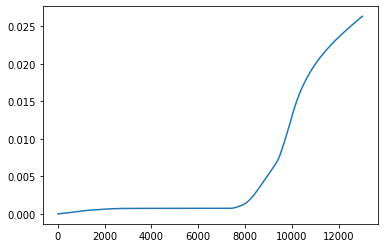

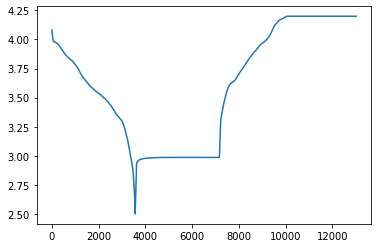

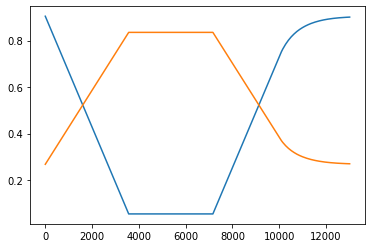

In [101]:
plt.plot(spm_sol["Time [s]"].data, spm_sol["Loss of Lithium Inventory [%]"].data)
plt.figure()
plt.plot(spm_sol["Time [s]"].data, spm_sol["Terminal voltage [V]"].data)
plt.figure()
plt.plot(spm_sol["Time [s]"].data, spm_sol["Negative electrode SOC"].data)
plt.plot(spm_sol["Time [s]"].data, spm_sol["Positive electrode SOC"].data)

In [102]:
lli = spm_sol["Loss of Lithium Inventory [%]"].data
lli_one_cycle = lli[-1] - lli[0]

## 10 cycles

In [103]:
pybamm.set_logging_level("NOTICE")
experiment = pybamm.Experiment([
    (f"Discharge at 1C until {Vmin}V",
     "Rest for 1 hour",
    f"Charge at 1C until {Vmax}V", 
    f"Hold at {Vmax}V until C/50")
] * 200)
sim_100 = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values)
spm_sol_100 = sim_100.solve()

2021-03-02 16:58:18,170 - [NOTICE] simulation.solve(693): Cycle 1/200 (25.608 ms elapsed) --------------------
2021-03-02 16:58:18,170 - [NOTICE] simulation.solve(723): Cycle 1/200, step 1/4: Discharge at 1C until 2.5V
2021-03-02 16:58:18,382 - [NOTICE] simulation.solve(723): Cycle 1/200, step 2/4: Rest for 1 hour
2021-03-02 16:58:18,579 - [NOTICE] simulation.solve(723): Cycle 1/200, step 3/4: Charge at 1C until 4.2V
2021-03-02 16:58:18,770 - [NOTICE] simulation.solve(723): Cycle 1/200, step 4/4: Hold at 4.2V until C/50
2021-03-02 16:58:19,164 - [NOTICE] simulation.solve(693): Cycle 2/200 (1.020 s elapsed) --------------------
2021-03-02 16:58:19,164 - [NOTICE] simulation.solve(723): Cycle 2/200, step 1/4: Discharge at 1C until 2.5V
2021-03-02 16:58:19,335 - [NOTICE] simulation.solve(723): Cycle 2/200, step 2/4: Rest for 1 hour
2021-03-02 16:58:19,502 - [NOTICE] simulation.solve(723): Cycle 2/200, step 3/4: Charge at 1C until 4.2V
2021-03-02 16:58:19,661 - [NOTICE] simulation.solve(723

2021-03-02 16:58:31,928 - [NOTICE] simulation.solve(723): Cycle 16/200, step 3/4: Charge at 1C until 4.2V
2021-03-02 16:58:32,085 - [NOTICE] simulation.solve(723): Cycle 16/200, step 4/4: Hold at 4.2V until C/50
2021-03-02 16:58:32,375 - [NOTICE] simulation.solve(693): Cycle 17/200 (14.230 s elapsed) --------------------
2021-03-02 16:58:32,376 - [NOTICE] simulation.solve(723): Cycle 17/200, step 1/4: Discharge at 1C until 2.5V
2021-03-02 16:58:32,573 - [NOTICE] simulation.solve(723): Cycle 17/200, step 2/4: Rest for 1 hour
2021-03-02 16:58:32,732 - [NOTICE] simulation.solve(723): Cycle 17/200, step 3/4: Charge at 1C until 4.2V
2021-03-02 16:58:32,887 - [NOTICE] simulation.solve(723): Cycle 17/200, step 4/4: Hold at 4.2V until C/50
2021-03-02 16:58:33,147 - [NOTICE] simulation.solve(693): Cycle 18/200 (15.002 s elapsed) --------------------
2021-03-02 16:58:33,147 - [NOTICE] simulation.solve(723): Cycle 18/200, step 1/4: Discharge at 1C until 2.5V
2021-03-02 16:58:33,338 - [NOTICE] sim

2021-03-02 16:58:44,500 - [NOTICE] simulation.solve(723): Cycle 32/200, step 1/4: Discharge at 1C until 2.5V
2021-03-02 16:58:44,720 - [NOTICE] simulation.solve(723): Cycle 32/200, step 2/4: Rest for 1 hour
2021-03-02 16:58:44,884 - [NOTICE] simulation.solve(723): Cycle 32/200, step 3/4: Charge at 1C until 4.2V
2021-03-02 16:58:45,065 - [NOTICE] simulation.solve(723): Cycle 32/200, step 4/4: Hold at 4.2V until C/50
2021-03-02 16:58:45,363 - [NOTICE] simulation.solve(693): Cycle 33/200 (27.218 s elapsed) --------------------
2021-03-02 16:58:45,363 - [NOTICE] simulation.solve(723): Cycle 33/200, step 1/4: Discharge at 1C until 2.5V
2021-03-02 16:58:45,555 - [NOTICE] simulation.solve(723): Cycle 33/200, step 2/4: Rest for 1 hour
2021-03-02 16:58:45,725 - [NOTICE] simulation.solve(723): Cycle 33/200, step 3/4: Charge at 1C until 4.2V
2021-03-02 16:58:45,892 - [NOTICE] simulation.solve(723): Cycle 33/200, step 4/4: Hold at 4.2V until C/50
2021-03-02 16:58:46,161 - [NOTICE] simulation.solve

2021-03-02 16:58:57,236 - [NOTICE] simulation.solve(723): Cycle 47/200, step 4/4: Hold at 4.2V until C/50
2021-03-02 16:58:57,496 - [NOTICE] simulation.solve(693): Cycle 48/200 (39.351 s elapsed) --------------------
2021-03-02 16:58:57,497 - [NOTICE] simulation.solve(723): Cycle 48/200, step 1/4: Discharge at 1C until 2.5V
2021-03-02 16:58:57,687 - [NOTICE] simulation.solve(723): Cycle 48/200, step 2/4: Rest for 1 hour
2021-03-02 16:58:57,865 - [NOTICE] simulation.solve(723): Cycle 48/200, step 3/4: Charge at 1C until 4.2V
2021-03-02 16:58:58,021 - [NOTICE] simulation.solve(723): Cycle 48/200, step 4/4: Hold at 4.2V until C/50
2021-03-02 16:58:58,277 - [NOTICE] simulation.solve(693): Cycle 49/200 (40.132 s elapsed) --------------------
2021-03-02 16:58:58,278 - [NOTICE] simulation.solve(723): Cycle 49/200, step 1/4: Discharge at 1C until 2.5V
2021-03-02 16:58:58,465 - [NOTICE] simulation.solve(723): Cycle 49/200, step 2/4: Rest for 1 hour
2021-03-02 16:58:58,647 - [NOTICE] simulation.

2021-03-02 16:59:09,485 - [NOTICE] simulation.solve(723): Cycle 63/200, step 2/4: Rest for 1 hour
2021-03-02 16:59:09,647 - [NOTICE] simulation.solve(723): Cycle 63/200, step 3/4: Charge at 1C until 4.2V
2021-03-02 16:59:09,815 - [NOTICE] simulation.solve(723): Cycle 63/200, step 4/4: Hold at 4.2V until C/50
2021-03-02 16:59:10,118 - [NOTICE] simulation.solve(693): Cycle 64/200 (51.968 s elapsed) --------------------
2021-03-02 16:59:10,121 - [NOTICE] simulation.solve(723): Cycle 64/200, step 1/4: Discharge at 1C until 2.5V
2021-03-02 16:59:10,305 - [NOTICE] simulation.solve(723): Cycle 64/200, step 2/4: Rest for 1 hour
2021-03-02 16:59:10,472 - [NOTICE] simulation.solve(723): Cycle 64/200, step 3/4: Charge at 1C until 4.2V
2021-03-02 16:59:10,621 - [NOTICE] simulation.solve(723): Cycle 64/200, step 4/4: Hold at 4.2V until C/50
2021-03-02 16:59:10,904 - [NOTICE] simulation.solve(693): Cycle 65/200 (52.754 s elapsed) --------------------
2021-03-02 16:59:10,904 - [NOTICE] simulation.sol

2021-03-02 16:59:22,003 - [NOTICE] simulation.solve(723): Cycle 78/200, step 4/4: Hold at 4.2V until C/50
2021-03-02 16:59:22,275 - [NOTICE] simulation.solve(693): Cycle 79/200 (1 minute, 4 seconds elapsed) --------------------
2021-03-02 16:59:22,276 - [NOTICE] simulation.solve(723): Cycle 79/200, step 1/4: Discharge at 1C until 2.5V
2021-03-02 16:59:22,465 - [NOTICE] simulation.solve(723): Cycle 79/200, step 2/4: Rest for 1 hour
2021-03-02 16:59:22,630 - [NOTICE] simulation.solve(723): Cycle 79/200, step 3/4: Charge at 1C until 4.2V
2021-03-02 16:59:22,794 - [NOTICE] simulation.solve(723): Cycle 79/200, step 4/4: Hold at 4.2V until C/50
2021-03-02 16:59:23,099 - [NOTICE] simulation.solve(693): Cycle 80/200 (1 minute, 5 seconds elapsed) --------------------
2021-03-02 16:59:23,099 - [NOTICE] simulation.solve(723): Cycle 80/200, step 1/4: Discharge at 1C until 2.5V
2021-03-02 16:59:23,278 - [NOTICE] simulation.solve(723): Cycle 80/200, step 2/4: Rest for 1 hour
2021-03-02 16:59:23,456 

2021-03-02 16:59:33,891 - [NOTICE] simulation.solve(693): Cycle 94/200 (1 minute, 16 seconds elapsed) --------------------
2021-03-02 16:59:33,892 - [NOTICE] simulation.solve(723): Cycle 94/200, step 1/4: Discharge at 1C until 2.5V
2021-03-02 16:59:34,059 - [NOTICE] simulation.solve(723): Cycle 94/200, step 2/4: Rest for 1 hour
2021-03-02 16:59:34,221 - [NOTICE] simulation.solve(723): Cycle 94/200, step 3/4: Charge at 1C until 4.2V
2021-03-02 16:59:34,356 - [NOTICE] simulation.solve(723): Cycle 94/200, step 4/4: Hold at 4.2V until C/50
2021-03-02 16:59:34,611 - [NOTICE] simulation.solve(693): Cycle 95/200 (1 minute, 16 seconds elapsed) --------------------
2021-03-02 16:59:34,611 - [NOTICE] simulation.solve(723): Cycle 95/200, step 1/4: Discharge at 1C until 2.5V
2021-03-02 16:59:34,778 - [NOTICE] simulation.solve(723): Cycle 95/200, step 2/4: Rest for 1 hour
2021-03-02 16:59:34,938 - [NOTICE] simulation.solve(723): Cycle 95/200, step 3/4: Charge at 1C until 4.2V
2021-03-02 16:59:35,07

2021-03-02 16:59:45,227 - [NOTICE] simulation.solve(723): Cycle 109/200, step 1/4: Discharge at 1C until 2.5V
2021-03-02 16:59:45,393 - [NOTICE] simulation.solve(723): Cycle 109/200, step 2/4: Rest for 1 hour
2021-03-02 16:59:45,553 - [NOTICE] simulation.solve(723): Cycle 109/200, step 3/4: Charge at 1C until 4.2V
2021-03-02 16:59:45,695 - [NOTICE] simulation.solve(723): Cycle 109/200, step 4/4: Hold at 4.2V until C/50
2021-03-02 16:59:45,955 - [NOTICE] simulation.solve(693): Cycle 110/200 (1 minute, 28 seconds elapsed) --------------------
2021-03-02 16:59:45,956 - [NOTICE] simulation.solve(723): Cycle 110/200, step 1/4: Discharge at 1C until 2.5V
2021-03-02 16:59:46,113 - [NOTICE] simulation.solve(723): Cycle 110/200, step 2/4: Rest for 1 hour
2021-03-02 16:59:46,278 - [NOTICE] simulation.solve(723): Cycle 110/200, step 3/4: Charge at 1C until 4.2V
2021-03-02 16:59:46,418 - [NOTICE] simulation.solve(723): Cycle 110/200, step 4/4: Hold at 4.2V until C/50
2021-03-02 16:59:46,671 - [NOT

2021-03-02 16:59:56,762 - [NOTICE] simulation.solve(723): Cycle 124/200, step 1/4: Discharge at 1C until 2.5V
2021-03-02 16:59:56,932 - [NOTICE] simulation.solve(723): Cycle 124/200, step 2/4: Rest for 1 hour
2021-03-02 16:59:57,091 - [NOTICE] simulation.solve(723): Cycle 124/200, step 3/4: Charge at 1C until 4.2V
2021-03-02 16:59:57,230 - [NOTICE] simulation.solve(723): Cycle 124/200, step 4/4: Hold at 4.2V until C/50
2021-03-02 16:59:57,487 - [NOTICE] simulation.solve(693): Cycle 125/200 (1 minute, 39 seconds elapsed) --------------------
2021-03-02 16:59:57,488 - [NOTICE] simulation.solve(723): Cycle 125/200, step 1/4: Discharge at 1C until 2.5V
2021-03-02 16:59:57,654 - [NOTICE] simulation.solve(723): Cycle 125/200, step 2/4: Rest for 1 hour
2021-03-02 16:59:57,826 - [NOTICE] simulation.solve(723): Cycle 125/200, step 3/4: Charge at 1C until 4.2V
2021-03-02 16:59:57,964 - [NOTICE] simulation.solve(723): Cycle 125/200, step 4/4: Hold at 4.2V until C/50
2021-03-02 16:59:58,237 - [NOT

2021-03-02 17:00:08,151 - [NOTICE] simulation.solve(723): Cycle 139/200, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:00:08,333 - [NOTICE] simulation.solve(723): Cycle 139/200, step 2/4: Rest for 1 hour
2021-03-02 17:00:08,514 - [NOTICE] simulation.solve(723): Cycle 139/200, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:00:08,658 - [NOTICE] simulation.solve(723): Cycle 139/200, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:00:08,917 - [NOTICE] simulation.solve(693): Cycle 140/200 (1 minute, 51 seconds elapsed) --------------------
2021-03-02 17:00:08,918 - [NOTICE] simulation.solve(723): Cycle 140/200, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:00:09,094 - [NOTICE] simulation.solve(723): Cycle 140/200, step 2/4: Rest for 1 hour
2021-03-02 17:00:09,254 - [NOTICE] simulation.solve(723): Cycle 140/200, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:00:09,397 - [NOTICE] simulation.solve(723): Cycle 140/200, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:00:09,664 - [NOT

2021-03-02 17:00:20,075 - [NOTICE] simulation.solve(723): Cycle 154/200, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:00:20,254 - [NOTICE] simulation.solve(723): Cycle 154/200, step 2/4: Rest for 1 hour
2021-03-02 17:00:20,441 - [NOTICE] simulation.solve(723): Cycle 154/200, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:00:20,587 - [NOTICE] simulation.solve(723): Cycle 154/200, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:00:20,884 - [NOTICE] simulation.solve(693): Cycle 155/200 (2 minutes, 3 seconds elapsed) --------------------
2021-03-02 17:00:20,885 - [NOTICE] simulation.solve(723): Cycle 155/200, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:00:21,064 - [NOTICE] simulation.solve(723): Cycle 155/200, step 2/4: Rest for 1 hour
2021-03-02 17:00:21,258 - [NOTICE] simulation.solve(723): Cycle 155/200, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:00:21,397 - [NOTICE] simulation.solve(723): Cycle 155/200, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:00:21,669 - [NOT

2021-03-02 17:00:33,029 - [NOTICE] simulation.solve(723): Cycle 169/200, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:00:33,199 - [NOTICE] simulation.solve(723): Cycle 169/200, step 2/4: Rest for 1 hour
2021-03-02 17:00:33,394 - [NOTICE] simulation.solve(723): Cycle 169/200, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:00:33,546 - [NOTICE] simulation.solve(723): Cycle 169/200, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:00:33,818 - [NOTICE] simulation.solve(693): Cycle 170/200 (2 minutes, 16 seconds elapsed) --------------------
2021-03-02 17:00:33,818 - [NOTICE] simulation.solve(723): Cycle 170/200, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:00:34,003 - [NOTICE] simulation.solve(723): Cycle 170/200, step 2/4: Rest for 1 hour
2021-03-02 17:00:34,192 - [NOTICE] simulation.solve(723): Cycle 170/200, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:00:34,343 - [NOTICE] simulation.solve(723): Cycle 170/200, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:00:34,610 - [NO

2021-03-02 17:00:44,738 - [NOTICE] simulation.solve(723): Cycle 184/200, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:00:44,902 - [NOTICE] simulation.solve(723): Cycle 184/200, step 2/4: Rest for 1 hour
2021-03-02 17:00:45,093 - [NOTICE] simulation.solve(723): Cycle 184/200, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:00:45,236 - [NOTICE] simulation.solve(723): Cycle 184/200, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:00:45,503 - [NOTICE] simulation.solve(693): Cycle 185/200 (2 minutes, 27 seconds elapsed) --------------------
2021-03-02 17:00:45,504 - [NOTICE] simulation.solve(723): Cycle 185/200, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:00:45,685 - [NOTICE] simulation.solve(723): Cycle 185/200, step 2/4: Rest for 1 hour
2021-03-02 17:00:45,874 - [NOTICE] simulation.solve(723): Cycle 185/200, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:00:46,021 - [NOTICE] simulation.solve(723): Cycle 185/200, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:00:46,287 - [NO

2021-03-02 17:00:56,371 - [NOTICE] simulation.solve(723): Cycle 199/200, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:00:56,567 - [NOTICE] simulation.solve(723): Cycle 199/200, step 2/4: Rest for 1 hour
2021-03-02 17:00:56,745 - [NOTICE] simulation.solve(723): Cycle 199/200, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:00:56,888 - [NOTICE] simulation.solve(723): Cycle 199/200, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:00:57,178 - [NOTICE] simulation.solve(693): Cycle 200/200 (2 minutes, 39 seconds elapsed) --------------------
2021-03-02 17:00:57,178 - [NOTICE] simulation.solve(723): Cycle 200/200, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:00:57,366 - [NOTICE] simulation.solve(723): Cycle 200/200, step 2/4: Rest for 1 hour
2021-03-02 17:00:57,536 - [NOTICE] simulation.solve(723): Cycle 200/200, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:00:57,680 - [NOTICE] simulation.solve(723): Cycle 200/200, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:00:57,957 - [NO

In [112]:
spm_sol_600.plot(["X-averaged outer negative electrode SEI thickness [m]"])

interactive(children=(FloatSlider(value=0.0, description='t', max=2055.0689912816006, step=20.550689912816004)…

In [105]:
spm_sol_400 = sim_100.solve(starting_solution=spm_sol_100)

2021-03-02 17:02:15,246 - [NOTICE] simulation.solve(693): Cycle 201/400 (29.401 ms elapsed) --------------------
2021-03-02 17:02:15,247 - [NOTICE] simulation.solve(723): Cycle 201/400, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:02:15,435 - [NOTICE] simulation.solve(723): Cycle 201/400, step 2/4: Rest for 1 hour
2021-03-02 17:02:15,604 - [NOTICE] simulation.solve(723): Cycle 201/400, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:02:15,800 - [NOTICE] simulation.solve(723): Cycle 201/400, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:02:16,209 - [NOTICE] simulation.solve(693): Cycle 202/400 (992.329 ms elapsed) --------------------
2021-03-02 17:02:16,209 - [NOTICE] simulation.solve(723): Cycle 202/400, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:02:16,397 - [NOTICE] simulation.solve(723): Cycle 202/400, step 2/4: Rest for 1 hour
2021-03-02 17:02:16,579 - [NOTICE] simulation.solve(723): Cycle 202/400, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:02:16,752 - [NOTICE]

2021-03-02 17:02:28,363 - [NOTICE] simulation.solve(723): Cycle 216/400, step 2/4: Rest for 1 hour
2021-03-02 17:02:28,553 - [NOTICE] simulation.solve(723): Cycle 216/400, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:02:28,722 - [NOTICE] simulation.solve(723): Cycle 216/400, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:02:29,000 - [NOTICE] simulation.solve(693): Cycle 217/400 (13.783 s elapsed) --------------------
2021-03-02 17:02:29,001 - [NOTICE] simulation.solve(723): Cycle 217/400, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:02:29,187 - [NOTICE] simulation.solve(723): Cycle 217/400, step 2/4: Rest for 1 hour
2021-03-02 17:02:29,393 - [NOTICE] simulation.solve(723): Cycle 217/400, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:02:29,571 - [NOTICE] simulation.solve(723): Cycle 217/400, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:02:29,865 - [NOTICE] simulation.solve(693): Cycle 218/400 (14.648 s elapsed) --------------------
2021-03-02 17:02:29,866 - [NOTICE] simul

2021-03-02 17:02:41,664 - [NOTICE] simulation.solve(723): Cycle 231/400, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:02:41,959 - [NOTICE] simulation.solve(693): Cycle 232/400 (26.742 s elapsed) --------------------
2021-03-02 17:02:41,959 - [NOTICE] simulation.solve(723): Cycle 232/400, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:02:42,132 - [NOTICE] simulation.solve(723): Cycle 232/400, step 2/4: Rest for 1 hour
2021-03-02 17:02:42,320 - [NOTICE] simulation.solve(723): Cycle 232/400, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:02:42,484 - [NOTICE] simulation.solve(723): Cycle 232/400, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:02:42,798 - [NOTICE] simulation.solve(693): Cycle 233/400 (27.581 s elapsed) --------------------
2021-03-02 17:02:42,799 - [NOTICE] simulation.solve(723): Cycle 233/400, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:02:42,983 - [NOTICE] simulation.solve(723): Cycle 233/400, step 2/4: Rest for 1 hour
2021-03-02 17:02:43,164 - [NOTICE] si

2021-03-02 17:02:55,080 - [NOTICE] simulation.solve(723): Cycle 247/400, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:02:55,284 - [NOTICE] simulation.solve(723): Cycle 247/400, step 2/4: Rest for 1 hour
2021-03-02 17:02:55,514 - [NOTICE] simulation.solve(723): Cycle 247/400, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:02:55,669 - [NOTICE] simulation.solve(723): Cycle 247/400, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:02:56,006 - [NOTICE] simulation.solve(693): Cycle 248/400 (40.789 s elapsed) --------------------
2021-03-02 17:02:56,007 - [NOTICE] simulation.solve(723): Cycle 248/400, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:02:56,204 - [NOTICE] simulation.solve(723): Cycle 248/400, step 2/4: Rest for 1 hour
2021-03-02 17:02:56,406 - [NOTICE] simulation.solve(723): Cycle 248/400, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:02:56,589 - [NOTICE] simulation.solve(723): Cycle 248/400, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:02:56,916 - [NOTICE] simulat

2021-03-02 17:03:07,834 - [NOTICE] simulation.solve(723): Cycle 262/400, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:03:08,011 - [NOTICE] simulation.solve(723): Cycle 262/400, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:03:08,329 - [NOTICE] simulation.solve(693): Cycle 263/400 (53.111 s elapsed) --------------------
2021-03-02 17:03:08,329 - [NOTICE] simulation.solve(723): Cycle 263/400, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:03:08,524 - [NOTICE] simulation.solve(723): Cycle 263/400, step 2/4: Rest for 1 hour
2021-03-02 17:03:08,706 - [NOTICE] simulation.solve(723): Cycle 263/400, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:03:08,859 - [NOTICE] simulation.solve(723): Cycle 263/400, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:03:09,138 - [NOTICE] simulation.solve(693): Cycle 264/400 (53.920 s elapsed) --------------------
2021-03-02 17:03:09,139 - [NOTICE] simulation.solve(723): Cycle 264/400, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:03:09,307 - [NO

2021-03-02 17:03:20,197 - [NOTICE] simulation.solve(723): Cycle 277/400, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:03:20,532 - [NOTICE] simulation.solve(693): Cycle 278/400 (1 minute, 5 seconds elapsed) --------------------
2021-03-02 17:03:20,532 - [NOTICE] simulation.solve(723): Cycle 278/400, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:03:20,719 - [NOTICE] simulation.solve(723): Cycle 278/400, step 2/4: Rest for 1 hour
2021-03-02 17:03:20,929 - [NOTICE] simulation.solve(723): Cycle 278/400, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:03:21,079 - [NOTICE] simulation.solve(723): Cycle 278/400, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:03:21,378 - [NOTICE] simulation.solve(693): Cycle 279/400 (1 minute, 6 seconds elapsed) --------------------
2021-03-02 17:03:21,379 - [NOTICE] simulation.solve(723): Cycle 279/400, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:03:21,548 - [NOTICE] simulation.solve(723): Cycle 279/400, step 2/4: Rest for 1 hour
2021-03-02 17:0

2021-03-02 17:03:32,423 - [NOTICE] simulation.solve(723): Cycle 292/400, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:03:32,700 - [NOTICE] simulation.solve(693): Cycle 293/400 (1 minute, 17 seconds elapsed) --------------------
2021-03-02 17:03:32,701 - [NOTICE] simulation.solve(723): Cycle 293/400, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:03:32,872 - [NOTICE] simulation.solve(723): Cycle 293/400, step 2/4: Rest for 1 hour
2021-03-02 17:03:33,054 - [NOTICE] simulation.solve(723): Cycle 293/400, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:03:33,207 - [NOTICE] simulation.solve(723): Cycle 293/400, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:03:33,486 - [NOTICE] simulation.solve(693): Cycle 294/400 (1 minute, 18 seconds elapsed) --------------------
2021-03-02 17:03:33,486 - [NOTICE] simulation.solve(723): Cycle 294/400, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:03:33,647 - [NOTICE] simulation.solve(723): Cycle 294/400, step 2/4: Rest for 1 hour
2021-03-02 17

2021-03-02 17:03:44,727 - [NOTICE] simulation.solve(723): Cycle 307/400, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:03:45,014 - [NOTICE] simulation.solve(693): Cycle 308/400 (1 minute, 30 seconds elapsed) --------------------
2021-03-02 17:03:45,015 - [NOTICE] simulation.solve(723): Cycle 308/400, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:03:45,176 - [NOTICE] simulation.solve(723): Cycle 308/400, step 2/4: Rest for 1 hour
2021-03-02 17:03:45,368 - [NOTICE] simulation.solve(723): Cycle 308/400, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:03:45,527 - [NOTICE] simulation.solve(723): Cycle 308/400, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:03:45,848 - [NOTICE] simulation.solve(693): Cycle 309/400 (1 minute, 31 seconds elapsed) --------------------
2021-03-02 17:03:45,849 - [NOTICE] simulation.solve(723): Cycle 309/400, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:03:46,044 - [NOTICE] simulation.solve(723): Cycle 309/400, step 2/4: Rest for 1 hour
2021-03-02 17

2021-03-02 17:03:57,921 - [NOTICE] simulation.solve(723): Cycle 322/400, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:03:58,246 - [NOTICE] simulation.solve(693): Cycle 323/400 (1 minute, 43 seconds elapsed) --------------------
2021-03-02 17:03:58,246 - [NOTICE] simulation.solve(723): Cycle 323/400, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:03:58,411 - [NOTICE] simulation.solve(723): Cycle 323/400, step 2/4: Rest for 1 hour
2021-03-02 17:03:58,639 - [NOTICE] simulation.solve(723): Cycle 323/400, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:03:58,818 - [NOTICE] simulation.solve(723): Cycle 323/400, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:03:59,122 - [NOTICE] simulation.solve(693): Cycle 324/400 (1 minute, 44 seconds elapsed) --------------------
2021-03-02 17:03:59,123 - [NOTICE] simulation.solve(723): Cycle 324/400, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:03:59,344 - [NOTICE] simulation.solve(723): Cycle 324/400, step 2/4: Rest for 1 hour
2021-03-02 17

2021-03-02 17:04:11,144 - [NOTICE] simulation.solve(723): Cycle 337/400, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:04:11,485 - [NOTICE] simulation.solve(693): Cycle 338/400 (1 minute, 56 seconds elapsed) --------------------
2021-03-02 17:04:11,486 - [NOTICE] simulation.solve(723): Cycle 338/400, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:04:11,683 - [NOTICE] simulation.solve(723): Cycle 338/400, step 2/4: Rest for 1 hour
2021-03-02 17:04:11,886 - [NOTICE] simulation.solve(723): Cycle 338/400, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:04:12,050 - [NOTICE] simulation.solve(723): Cycle 338/400, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:04:12,335 - [NOTICE] simulation.solve(693): Cycle 339/400 (1 minute, 57 seconds elapsed) --------------------
2021-03-02 17:04:12,336 - [NOTICE] simulation.solve(723): Cycle 339/400, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:04:12,536 - [NOTICE] simulation.solve(723): Cycle 339/400, step 2/4: Rest for 1 hour
2021-03-02 17

2021-03-02 17:04:24,320 - [NOTICE] simulation.solve(723): Cycle 352/400, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:04:24,642 - [NOTICE] simulation.solve(693): Cycle 353/400 (2 minutes, 9 seconds elapsed) --------------------
2021-03-02 17:04:24,643 - [NOTICE] simulation.solve(723): Cycle 353/400, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:04:24,835 - [NOTICE] simulation.solve(723): Cycle 353/400, step 2/4: Rest for 1 hour
2021-03-02 17:04:25,027 - [NOTICE] simulation.solve(723): Cycle 353/400, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:04:25,206 - [NOTICE] simulation.solve(723): Cycle 353/400, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:04:27,360 - [NOTICE] simulation.solve(693): Cycle 354/400 (2 minutes, 12 seconds elapsed) --------------------
2021-03-02 17:04:27,361 - [NOTICE] simulation.solve(723): Cycle 354/400, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:04:27,536 - [NOTICE] simulation.solve(723): Cycle 354/400, step 2/4: Rest for 1 hour
2021-03-02 1

2021-03-02 17:04:39,730 - [NOTICE] simulation.solve(723): Cycle 367/400, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:04:40,081 - [NOTICE] simulation.solve(693): Cycle 368/400 (2 minutes, 25 seconds elapsed) --------------------
2021-03-02 17:04:40,081 - [NOTICE] simulation.solve(723): Cycle 368/400, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:04:40,262 - [NOTICE] simulation.solve(723): Cycle 368/400, step 2/4: Rest for 1 hour
2021-03-02 17:04:40,449 - [NOTICE] simulation.solve(723): Cycle 368/400, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:04:40,629 - [NOTICE] simulation.solve(723): Cycle 368/400, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:04:40,963 - [NOTICE] simulation.solve(693): Cycle 369/400 (2 minutes, 26 seconds elapsed) --------------------
2021-03-02 17:04:40,963 - [NOTICE] simulation.solve(723): Cycle 369/400, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:04:41,181 - [NOTICE] simulation.solve(723): Cycle 369/400, step 2/4: Rest for 1 hour
2021-03-02 

2021-03-02 17:04:53,463 - [NOTICE] simulation.solve(723): Cycle 382/400, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:04:53,775 - [NOTICE] simulation.solve(693): Cycle 383/400 (2 minutes, 39 seconds elapsed) --------------------
2021-03-02 17:04:53,775 - [NOTICE] simulation.solve(723): Cycle 383/400, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:04:53,996 - [NOTICE] simulation.solve(723): Cycle 383/400, step 2/4: Rest for 1 hour
2021-03-02 17:04:54,198 - [NOTICE] simulation.solve(723): Cycle 383/400, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:04:54,366 - [NOTICE] simulation.solve(723): Cycle 383/400, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:04:54,694 - [NOTICE] simulation.solve(693): Cycle 384/400 (2 minutes, 39 seconds elapsed) --------------------
2021-03-02 17:04:54,695 - [NOTICE] simulation.solve(723): Cycle 384/400, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:04:54,871 - [NOTICE] simulation.solve(723): Cycle 384/400, step 2/4: Rest for 1 hour
2021-03-02 

2021-03-02 17:05:07,092 - [NOTICE] simulation.solve(723): Cycle 397/400, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:05:07,412 - [NOTICE] simulation.solve(693): Cycle 398/400 (2 minutes, 52 seconds elapsed) --------------------
2021-03-02 17:05:07,413 - [NOTICE] simulation.solve(723): Cycle 398/400, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:05:07,605 - [NOTICE] simulation.solve(723): Cycle 398/400, step 2/4: Rest for 1 hour
2021-03-02 17:05:07,797 - [NOTICE] simulation.solve(723): Cycle 398/400, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:05:07,997 - [NOTICE] simulation.solve(723): Cycle 398/400, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:05:08,315 - [NOTICE] simulation.solve(693): Cycle 399/400 (2 minutes, 53 seconds elapsed) --------------------
2021-03-02 17:05:08,316 - [NOTICE] simulation.solve(723): Cycle 399/400, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:05:08,512 - [NOTICE] simulation.solve(723): Cycle 399/400, step 2/4: Rest for 1 hour
2021-03-02 

In [111]:
spm_sol_600 = sim_100.solve(starting_solution=spm_sol_400)

2021-03-02 17:15:56,754 - [NOTICE] simulation.solve(693): Cycle 401/600 (29.555 ms elapsed) --------------------
2021-03-02 17:15:56,755 - [NOTICE] simulation.solve(723): Cycle 401/600, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:15:56,939 - [NOTICE] simulation.solve(723): Cycle 401/600, step 2/4: Rest for 1 hour
2021-03-02 17:15:57,140 - [NOTICE] simulation.solve(723): Cycle 401/600, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:15:57,332 - [NOTICE] simulation.solve(723): Cycle 401/600, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:15:57,758 - [NOTICE] simulation.solve(693): Cycle 402/600 (1.033 s elapsed) --------------------
2021-03-02 17:15:57,759 - [NOTICE] simulation.solve(723): Cycle 402/600, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:15:57,952 - [NOTICE] simulation.solve(723): Cycle 402/600, step 2/4: Rest for 1 hour
2021-03-02 17:15:58,184 - [NOTICE] simulation.solve(723): Cycle 402/600, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:15:58,370 - [NOTICE] si

2021-03-02 17:16:11,183 - [NOTICE] simulation.solve(723): Cycle 416/600, step 2/4: Rest for 1 hour
2021-03-02 17:16:11,390 - [NOTICE] simulation.solve(723): Cycle 416/600, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:16:11,576 - [NOTICE] simulation.solve(723): Cycle 416/600, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:16:11,880 - [NOTICE] simulation.solve(693): Cycle 417/600 (15.155 s elapsed) --------------------
2021-03-02 17:16:11,880 - [NOTICE] simulation.solve(723): Cycle 417/600, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:16:12,057 - [NOTICE] simulation.solve(723): Cycle 417/600, step 2/4: Rest for 1 hour
2021-03-02 17:16:12,261 - [NOTICE] simulation.solve(723): Cycle 417/600, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:16:12,433 - [NOTICE] simulation.solve(723): Cycle 417/600, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:16:12,762 - [NOTICE] simulation.solve(693): Cycle 418/600 (16.037 s elapsed) --------------------
2021-03-02 17:16:12,762 - [NOTICE] simul

2021-03-02 17:16:25,344 - [NOTICE] simulation.solve(723): Cycle 431/600, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:16:25,655 - [NOTICE] simulation.solve(693): Cycle 432/600 (28.930 s elapsed) --------------------
2021-03-02 17:16:25,656 - [NOTICE] simulation.solve(723): Cycle 432/600, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:16:25,865 - [NOTICE] simulation.solve(723): Cycle 432/600, step 2/4: Rest for 1 hour
2021-03-02 17:16:26,081 - [NOTICE] simulation.solve(723): Cycle 432/600, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:16:26,260 - [NOTICE] simulation.solve(723): Cycle 432/600, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:16:26,587 - [NOTICE] simulation.solve(693): Cycle 433/600 (29.862 s elapsed) --------------------
2021-03-02 17:16:26,588 - [NOTICE] simulation.solve(723): Cycle 433/600, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:16:26,784 - [NOTICE] simulation.solve(723): Cycle 433/600, step 2/4: Rest for 1 hour
2021-03-02 17:16:27,002 - [NOTICE] si

2021-03-02 17:16:39,634 - [NOTICE] simulation.solve(723): Cycle 447/600, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:16:39,816 - [NOTICE] simulation.solve(723): Cycle 447/600, step 2/4: Rest for 1 hour
2021-03-02 17:16:40,012 - [NOTICE] simulation.solve(723): Cycle 447/600, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:16:40,182 - [NOTICE] simulation.solve(723): Cycle 447/600, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:16:40,482 - [NOTICE] simulation.solve(693): Cycle 448/600 (43.756 s elapsed) --------------------
2021-03-02 17:16:40,483 - [NOTICE] simulation.solve(723): Cycle 448/600, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:16:40,653 - [NOTICE] simulation.solve(723): Cycle 448/600, step 2/4: Rest for 1 hour
2021-03-02 17:16:40,853 - [NOTICE] simulation.solve(723): Cycle 448/600, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:16:41,015 - [NOTICE] simulation.solve(723): Cycle 448/600, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:16:41,332 - [NOTICE] simulat

2021-03-02 17:16:55,408 - [NOTICE] simulation.solve(723): Cycle 462/600, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:16:55,580 - [NOTICE] simulation.solve(723): Cycle 462/600, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:16:55,880 - [NOTICE] simulation.solve(693): Cycle 463/600 (59.153 s elapsed) --------------------
2021-03-02 17:16:55,880 - [NOTICE] simulation.solve(723): Cycle 463/600, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:16:56,057 - [NOTICE] simulation.solve(723): Cycle 463/600, step 2/4: Rest for 1 hour
2021-03-02 17:16:56,287 - [NOTICE] simulation.solve(723): Cycle 463/600, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:16:56,462 - [NOTICE] simulation.solve(723): Cycle 463/600, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:16:56,810 - [NOTICE] simulation.solve(693): Cycle 464/600 (1 minute, 0 seconds elapsed) --------------------
2021-03-02 17:16:56,811 - [NOTICE] simulation.solve(723): Cycle 464/600, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:16:5

2021-03-02 17:17:08,765 - [NOTICE] simulation.solve(723): Cycle 477/600, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:17:09,076 - [NOTICE] simulation.solve(693): Cycle 478/600 (1 minute, 12 seconds elapsed) --------------------
2021-03-02 17:17:09,077 - [NOTICE] simulation.solve(723): Cycle 478/600, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:17:09,250 - [NOTICE] simulation.solve(723): Cycle 478/600, step 2/4: Rest for 1 hour
2021-03-02 17:17:09,451 - [NOTICE] simulation.solve(723): Cycle 478/600, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:17:09,634 - [NOTICE] simulation.solve(723): Cycle 478/600, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:17:09,945 - [NOTICE] simulation.solve(693): Cycle 479/600 (1 minute, 13 seconds elapsed) --------------------
2021-03-02 17:17:09,960 - [NOTICE] simulation.solve(723): Cycle 479/600, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:17:10,134 - [NOTICE] simulation.solve(723): Cycle 479/600, step 2/4: Rest for 1 hour
2021-03-02 17

2021-03-02 17:17:22,250 - [NOTICE] simulation.solve(723): Cycle 492/600, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:17:22,575 - [NOTICE] simulation.solve(693): Cycle 493/600 (1 minute, 26 seconds elapsed) --------------------
2021-03-02 17:17:22,576 - [NOTICE] simulation.solve(723): Cycle 493/600, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:17:22,763 - [NOTICE] simulation.solve(723): Cycle 493/600, step 2/4: Rest for 1 hour
2021-03-02 17:17:22,988 - [NOTICE] simulation.solve(723): Cycle 493/600, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:17:23,171 - [NOTICE] simulation.solve(723): Cycle 493/600, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:17:23,538 - [NOTICE] simulation.solve(693): Cycle 494/600 (1 minute, 27 seconds elapsed) --------------------
2021-03-02 17:17:23,538 - [NOTICE] simulation.solve(723): Cycle 494/600, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:17:23,731 - [NOTICE] simulation.solve(723): Cycle 494/600, step 2/4: Rest for 1 hour
2021-03-02 17

2021-03-02 17:17:36,067 - [NOTICE] simulation.solve(723): Cycle 507/600, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:17:36,399 - [NOTICE] simulation.solve(693): Cycle 508/600 (1 minute, 40 seconds elapsed) --------------------
2021-03-02 17:17:36,399 - [NOTICE] simulation.solve(723): Cycle 508/600, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:17:36,592 - [NOTICE] simulation.solve(723): Cycle 508/600, step 2/4: Rest for 1 hour
2021-03-02 17:17:36,838 - [NOTICE] simulation.solve(723): Cycle 508/600, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:17:37,007 - [NOTICE] simulation.solve(723): Cycle 508/600, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:17:37,349 - [NOTICE] simulation.solve(693): Cycle 509/600 (1 minute, 41 seconds elapsed) --------------------
2021-03-02 17:17:37,350 - [NOTICE] simulation.solve(723): Cycle 509/600, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:17:37,568 - [NOTICE] simulation.solve(723): Cycle 509/600, step 2/4: Rest for 1 hour
2021-03-02 17

2021-03-02 17:17:50,855 - [NOTICE] simulation.solve(723): Cycle 522/600, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:17:51,190 - [NOTICE] simulation.solve(693): Cycle 523/600 (1 minute, 54 seconds elapsed) --------------------
2021-03-02 17:17:51,191 - [NOTICE] simulation.solve(723): Cycle 523/600, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:17:51,363 - [NOTICE] simulation.solve(723): Cycle 523/600, step 2/4: Rest for 1 hour
2021-03-02 17:17:51,592 - [NOTICE] simulation.solve(723): Cycle 523/600, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:17:51,770 - [NOTICE] simulation.solve(723): Cycle 523/600, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:17:52,108 - [NOTICE] simulation.solve(693): Cycle 524/600 (1 minute, 55 seconds elapsed) --------------------
2021-03-02 17:17:52,109 - [NOTICE] simulation.solve(723): Cycle 524/600, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:17:52,287 - [NOTICE] simulation.solve(723): Cycle 524/600, step 2/4: Rest for 1 hour
2021-03-02 17

2021-03-02 17:18:04,546 - [NOTICE] simulation.solve(723): Cycle 537/600, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:18:04,872 - [NOTICE] simulation.solve(693): Cycle 538/600 (2 minutes, 8 seconds elapsed) --------------------
2021-03-02 17:18:04,873 - [NOTICE] simulation.solve(723): Cycle 538/600, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:18:05,043 - [NOTICE] simulation.solve(723): Cycle 538/600, step 2/4: Rest for 1 hour
2021-03-02 17:18:05,266 - [NOTICE] simulation.solve(723): Cycle 538/600, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:18:05,443 - [NOTICE] simulation.solve(723): Cycle 538/600, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:18:05,768 - [NOTICE] simulation.solve(693): Cycle 539/600 (2 minutes, 9 seconds elapsed) --------------------
2021-03-02 17:18:05,769 - [NOTICE] simulation.solve(723): Cycle 539/600, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:18:05,980 - [NOTICE] simulation.solve(723): Cycle 539/600, step 2/4: Rest for 1 hour
2021-03-02 17

2021-03-02 17:18:18,319 - [NOTICE] simulation.solve(723): Cycle 552/600, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:18:18,667 - [NOTICE] simulation.solve(693): Cycle 553/600 (2 minutes, 22 seconds elapsed) --------------------
2021-03-02 17:18:18,667 - [NOTICE] simulation.solve(723): Cycle 553/600, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:18:18,850 - [NOTICE] simulation.solve(723): Cycle 553/600, step 2/4: Rest for 1 hour
2021-03-02 17:18:19,081 - [NOTICE] simulation.solve(723): Cycle 553/600, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:18:19,257 - [NOTICE] simulation.solve(723): Cycle 553/600, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:18:19,572 - [NOTICE] simulation.solve(693): Cycle 554/600 (2 minutes, 23 seconds elapsed) --------------------
2021-03-02 17:18:19,573 - [NOTICE] simulation.solve(723): Cycle 554/600, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:18:19,739 - [NOTICE] simulation.solve(723): Cycle 554/600, step 2/4: Rest for 1 hour
2021-03-02 

2021-03-02 17:18:34,071 - [NOTICE] simulation.solve(723): Cycle 567/600, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:18:34,402 - [NOTICE] simulation.solve(693): Cycle 568/600 (2 minutes, 38 seconds elapsed) --------------------
2021-03-02 17:18:34,402 - [NOTICE] simulation.solve(723): Cycle 568/600, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:18:34,598 - [NOTICE] simulation.solve(723): Cycle 568/600, step 2/4: Rest for 1 hour
2021-03-02 17:18:34,806 - [NOTICE] simulation.solve(723): Cycle 568/600, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:18:34,975 - [NOTICE] simulation.solve(723): Cycle 568/600, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:18:35,321 - [NOTICE] simulation.solve(693): Cycle 569/600 (2 minutes, 39 seconds elapsed) --------------------
2021-03-02 17:18:35,322 - [NOTICE] simulation.solve(723): Cycle 569/600, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:18:35,501 - [NOTICE] simulation.solve(723): Cycle 569/600, step 2/4: Rest for 1 hour
2021-03-02 

2021-03-02 17:18:47,917 - [NOTICE] simulation.solve(723): Cycle 582/600, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:18:48,238 - [NOTICE] simulation.solve(693): Cycle 583/600 (2 minutes, 52 seconds elapsed) --------------------
2021-03-02 17:18:48,239 - [NOTICE] simulation.solve(723): Cycle 583/600, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:18:48,422 - [NOTICE] simulation.solve(723): Cycle 583/600, step 2/4: Rest for 1 hour
2021-03-02 17:18:48,652 - [NOTICE] simulation.solve(723): Cycle 583/600, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:18:48,825 - [NOTICE] simulation.solve(723): Cycle 583/600, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:18:49,153 - [NOTICE] simulation.solve(693): Cycle 584/600 (2 minutes, 52 seconds elapsed) --------------------
2021-03-02 17:18:49,154 - [NOTICE] simulation.solve(723): Cycle 584/600, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:18:49,330 - [NOTICE] simulation.solve(723): Cycle 584/600, step 2/4: Rest for 1 hour
2021-03-02 

2021-03-02 17:19:01,854 - [NOTICE] simulation.solve(723): Cycle 597/600, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:19:02,175 - [NOTICE] simulation.solve(693): Cycle 598/600 (3 minutes, 5 seconds elapsed) --------------------
2021-03-02 17:19:02,176 - [NOTICE] simulation.solve(723): Cycle 598/600, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:19:02,375 - [NOTICE] simulation.solve(723): Cycle 598/600, step 2/4: Rest for 1 hour
2021-03-02 17:19:02,615 - [NOTICE] simulation.solve(723): Cycle 598/600, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:19:02,787 - [NOTICE] simulation.solve(723): Cycle 598/600, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:19:03,090 - [NOTICE] simulation.solve(693): Cycle 599/600 (3 minutes, 6 seconds elapsed) --------------------
2021-03-02 17:19:03,107 - [NOTICE] simulation.solve(723): Cycle 599/600, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:19:03,285 - [NOTICE] simulation.solve(723): Cycle 599/600, step 2/4: Rest for 1 hour
2021-03-02 17

In [121]:
spm_sol_800 = sim_100.solve(starting_solution=spm_sol_600)

2021-03-02 17:28:46,071 - [NOTICE] simulation.solve(693): Cycle 601/800 (35.804 ms elapsed) --------------------
2021-03-02 17:28:46,072 - [NOTICE] simulation.solve(723): Cycle 601/800, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:28:46,280 - [NOTICE] simulation.solve(723): Cycle 601/800, step 2/4: Rest for 1 hour
2021-03-02 17:28:46,490 - [NOTICE] simulation.solve(723): Cycle 601/800, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:28:46,682 - [NOTICE] simulation.solve(723): Cycle 601/800, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:28:47,133 - [NOTICE] simulation.solve(693): Cycle 602/800 (1.098 s elapsed) --------------------
2021-03-02 17:28:47,134 - [NOTICE] simulation.solve(723): Cycle 602/800, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:28:47,326 - [NOTICE] simulation.solve(723): Cycle 602/800, step 2/4: Rest for 1 hour
2021-03-02 17:28:47,552 - [NOTICE] simulation.solve(723): Cycle 602/800, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:28:47,749 - [NOTICE] si

2021-03-02 17:29:00,685 - [NOTICE] simulation.solve(723): Cycle 616/800, step 2/4: Rest for 1 hour
2021-03-02 17:29:00,902 - [NOTICE] simulation.solve(723): Cycle 616/800, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:29:01,100 - [NOTICE] simulation.solve(723): Cycle 616/800, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:29:01,429 - [NOTICE] simulation.solve(693): Cycle 617/800 (15.398 s elapsed) --------------------
2021-03-02 17:29:01,430 - [NOTICE] simulation.solve(723): Cycle 617/800, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:29:01,622 - [NOTICE] simulation.solve(723): Cycle 617/800, step 2/4: Rest for 1 hour
2021-03-02 17:29:01,856 - [NOTICE] simulation.solve(723): Cycle 617/800, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:29:02,031 - [NOTICE] simulation.solve(723): Cycle 617/800, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:29:02,398 - [NOTICE] simulation.solve(693): Cycle 618/800 (16.368 s elapsed) --------------------
2021-03-02 17:29:02,399 - [NOTICE] simul

2021-03-02 17:29:15,451 - [NOTICE] simulation.solve(723): Cycle 631/800, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:29:15,783 - [NOTICE] simulation.solve(693): Cycle 632/800 (29.772 s elapsed) --------------------
2021-03-02 17:29:15,784 - [NOTICE] simulation.solve(723): Cycle 632/800, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:29:15,963 - [NOTICE] simulation.solve(723): Cycle 632/800, step 2/4: Rest for 1 hour
2021-03-02 17:29:16,185 - [NOTICE] simulation.solve(723): Cycle 632/800, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:29:16,365 - [NOTICE] simulation.solve(723): Cycle 632/800, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:29:16,705 - [NOTICE] simulation.solve(693): Cycle 633/800 (30.695 s elapsed) --------------------
2021-03-02 17:29:16,706 - [NOTICE] simulation.solve(723): Cycle 633/800, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:29:16,901 - [NOTICE] simulation.solve(723): Cycle 633/800, step 2/4: Rest for 1 hour
2021-03-02 17:29:17,154 - [NOTICE] si

2021-03-02 17:29:30,109 - [NOTICE] simulation.solve(723): Cycle 647/800, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:29:30,283 - [NOTICE] simulation.solve(723): Cycle 647/800, step 2/4: Rest for 1 hour
2021-03-02 17:29:30,503 - [NOTICE] simulation.solve(723): Cycle 647/800, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:29:30,689 - [NOTICE] simulation.solve(723): Cycle 647/800, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:29:31,037 - [NOTICE] simulation.solve(693): Cycle 648/800 (45.035 s elapsed) --------------------
2021-03-02 17:29:31,038 - [NOTICE] simulation.solve(723): Cycle 648/800, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:29:31,241 - [NOTICE] simulation.solve(723): Cycle 648/800, step 2/4: Rest for 1 hour
2021-03-02 17:29:31,449 - [NOTICE] simulation.solve(723): Cycle 648/800, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:29:31,624 - [NOTICE] simulation.solve(723): Cycle 648/800, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:29:31,957 - [NOTICE] simulat

2021-03-02 17:29:47,053 - [NOTICE] simulation.solve(723): Cycle 662/800, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:29:47,250 - [NOTICE] simulation.solve(723): Cycle 662/800, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:29:47,604 - [NOTICE] simulation.solve(693): Cycle 663/800 (1 minute, 2 seconds elapsed) --------------------
2021-03-02 17:29:47,605 - [NOTICE] simulation.solve(723): Cycle 663/800, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:29:47,810 - [NOTICE] simulation.solve(723): Cycle 663/800, step 2/4: Rest for 1 hour
2021-03-02 17:29:48,018 - [NOTICE] simulation.solve(723): Cycle 663/800, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:29:48,202 - [NOTICE] simulation.solve(723): Cycle 663/800, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:29:48,539 - [NOTICE] simulation.solve(693): Cycle 664/800 (1 minute, 3 seconds elapsed) --------------------
2021-03-02 17:29:48,539 - [NOTICE] simulation.solve(723): Cycle 664/800, step 1/4: Discharge at 1C until 2.5V
2021-03

2021-03-02 17:30:01,494 - [NOTICE] simulation.solve(723): Cycle 677/800, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:30:01,692 - [NOTICE] simulation.solve(723): Cycle 677/800, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:30:02,037 - [NOTICE] simulation.solve(693): Cycle 678/800 (1 minute, 16 seconds elapsed) --------------------
2021-03-02 17:30:02,037 - [NOTICE] simulation.solve(723): Cycle 678/800, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:30:02,241 - [NOTICE] simulation.solve(723): Cycle 678/800, step 2/4: Rest for 1 hour
2021-03-02 17:30:02,475 - [NOTICE] simulation.solve(723): Cycle 678/800, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:30:02,670 - [NOTICE] simulation.solve(723): Cycle 678/800, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:30:03,006 - [NOTICE] simulation.solve(693): Cycle 679/800 (1 minute, 17 seconds elapsed) --------------------
2021-03-02 17:30:03,007 - [NOTICE] simulation.solve(723): Cycle 679/800, step 1/4: Discharge at 1C until 2.5V
2021-

2021-03-02 17:30:15,985 - [NOTICE] simulation.solve(723): Cycle 692/800, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:30:16,176 - [NOTICE] simulation.solve(723): Cycle 692/800, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:30:16,509 - [NOTICE] simulation.solve(693): Cycle 693/800 (1 minute, 31 seconds elapsed) --------------------
2021-03-02 17:30:16,510 - [NOTICE] simulation.solve(723): Cycle 693/800, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:30:16,699 - [NOTICE] simulation.solve(723): Cycle 693/800, step 2/4: Rest for 1 hour
2021-03-02 17:30:16,931 - [NOTICE] simulation.solve(723): Cycle 693/800, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:30:17,117 - [NOTICE] simulation.solve(723): Cycle 693/800, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:30:17,472 - [NOTICE] simulation.solve(693): Cycle 694/800 (1 minute, 31 seconds elapsed) --------------------
2021-03-02 17:30:17,473 - [NOTICE] simulation.solve(723): Cycle 694/800, step 1/4: Discharge at 1C until 2.5V
2021-

2021-03-02 17:30:30,482 - [NOTICE] simulation.solve(723): Cycle 707/800, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:30:30,654 - [NOTICE] simulation.solve(723): Cycle 707/800, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:30:30,956 - [NOTICE] simulation.solve(693): Cycle 708/800 (1 minute, 45 seconds elapsed) --------------------
2021-03-02 17:30:30,957 - [NOTICE] simulation.solve(723): Cycle 708/800, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:30:31,170 - [NOTICE] simulation.solve(723): Cycle 708/800, step 2/4: Rest for 1 hour
2021-03-02 17:30:31,393 - [NOTICE] simulation.solve(723): Cycle 708/800, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:30:31,581 - [NOTICE] simulation.solve(723): Cycle 708/800, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:30:31,908 - [NOTICE] simulation.solve(693): Cycle 709/800 (1 minute, 46 seconds elapsed) --------------------
2021-03-02 17:30:31,929 - [NOTICE] simulation.solve(723): Cycle 709/800, step 1/4: Discharge at 1C until 2.5V
2021-

2021-03-02 17:30:46,070 - [NOTICE] simulation.solve(723): Cycle 722/800, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:30:46,307 - [NOTICE] simulation.solve(723): Cycle 722/800, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:30:46,640 - [NOTICE] simulation.solve(693): Cycle 723/800 (2 minutes, 1 second elapsed) --------------------
2021-03-02 17:30:46,641 - [NOTICE] simulation.solve(723): Cycle 723/800, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:30:46,857 - [NOTICE] simulation.solve(723): Cycle 723/800, step 2/4: Rest for 1 hour
2021-03-02 17:30:47,099 - [NOTICE] simulation.solve(723): Cycle 723/800, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:30:47,290 - [NOTICE] simulation.solve(723): Cycle 723/800, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:30:47,666 - [NOTICE] simulation.solve(693): Cycle 724/800 (2 minutes, 2 seconds elapsed) --------------------
2021-03-02 17:30:47,667 - [NOTICE] simulation.solve(723): Cycle 724/800, step 1/4: Discharge at 1C until 2.5V
2021-0

2021-03-02 17:31:01,297 - [NOTICE] simulation.solve(723): Cycle 737/800, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:31:01,500 - [NOTICE] simulation.solve(723): Cycle 737/800, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:31:01,845 - [NOTICE] simulation.solve(693): Cycle 738/800 (2 minutes, 16 seconds elapsed) --------------------
2021-03-02 17:31:01,846 - [NOTICE] simulation.solve(723): Cycle 738/800, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:31:02,038 - [NOTICE] simulation.solve(723): Cycle 738/800, step 2/4: Rest for 1 hour
2021-03-02 17:31:02,278 - [NOTICE] simulation.solve(723): Cycle 738/800, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:31:02,476 - [NOTICE] simulation.solve(723): Cycle 738/800, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:31:02,861 - [NOTICE] simulation.solve(693): Cycle 739/800 (2 minutes, 17 seconds elapsed) --------------------
2021-03-02 17:31:02,862 - [NOTICE] simulation.solve(723): Cycle 739/800, step 1/4: Discharge at 1C until 2.5V
202

2021-03-02 17:31:16,347 - [NOTICE] simulation.solve(723): Cycle 752/800, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:31:16,544 - [NOTICE] simulation.solve(723): Cycle 752/800, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:31:16,907 - [NOTICE] simulation.solve(693): Cycle 753/800 (2 minutes, 31 seconds elapsed) --------------------
2021-03-02 17:31:16,908 - [NOTICE] simulation.solve(723): Cycle 753/800, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:31:17,112 - [NOTICE] simulation.solve(723): Cycle 753/800, step 2/4: Rest for 1 hour
2021-03-02 17:31:17,352 - [NOTICE] simulation.solve(723): Cycle 753/800, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:31:17,553 - [NOTICE] simulation.solve(723): Cycle 753/800, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:31:17,922 - [NOTICE] simulation.solve(693): Cycle 754/800 (2 minutes, 32 seconds elapsed) --------------------
2021-03-02 17:31:17,922 - [NOTICE] simulation.solve(723): Cycle 754/800, step 1/4: Discharge at 1C until 2.5V
202

2021-03-02 17:31:31,350 - [NOTICE] simulation.solve(723): Cycle 767/800, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:31:31,541 - [NOTICE] simulation.solve(723): Cycle 767/800, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:31:31,880 - [NOTICE] simulation.solve(693): Cycle 768/800 (2 minutes, 46 seconds elapsed) --------------------
2021-03-02 17:31:31,881 - [NOTICE] simulation.solve(723): Cycle 768/800, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:31:32,067 - [NOTICE] simulation.solve(723): Cycle 768/800, step 2/4: Rest for 1 hour
2021-03-02 17:31:32,315 - [NOTICE] simulation.solve(723): Cycle 768/800, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:31:32,512 - [NOTICE] simulation.solve(723): Cycle 768/800, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:31:32,848 - [NOTICE] simulation.solve(693): Cycle 769/800 (2 minutes, 47 seconds elapsed) --------------------
2021-03-02 17:31:32,849 - [NOTICE] simulation.solve(723): Cycle 769/800, step 1/4: Discharge at 1C until 2.5V
202

2021-03-02 17:31:46,042 - [NOTICE] simulation.solve(723): Cycle 782/800, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:31:46,235 - [NOTICE] simulation.solve(723): Cycle 782/800, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:31:46,577 - [NOTICE] simulation.solve(693): Cycle 783/800 (3 minutes, 1 second elapsed) --------------------
2021-03-02 17:31:46,599 - [NOTICE] simulation.solve(723): Cycle 783/800, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:31:46,825 - [NOTICE] simulation.solve(723): Cycle 783/800, step 2/4: Rest for 1 hour
2021-03-02 17:31:47,050 - [NOTICE] simulation.solve(723): Cycle 783/800, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:31:47,244 - [NOTICE] simulation.solve(723): Cycle 783/800, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:31:47,600 - [NOTICE] simulation.solve(693): Cycle 784/800 (3 minutes, 2 seconds elapsed) --------------------
2021-03-02 17:31:47,600 - [NOTICE] simulation.solve(723): Cycle 784/800, step 1/4: Discharge at 1C until 2.5V
2021-0

2021-03-02 17:32:00,812 - [NOTICE] simulation.solve(723): Cycle 797/800, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:32:01,012 - [NOTICE] simulation.solve(723): Cycle 797/800, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:32:01,349 - [NOTICE] simulation.solve(693): Cycle 798/800 (3 minutes, 15 seconds elapsed) --------------------
2021-03-02 17:32:01,350 - [NOTICE] simulation.solve(723): Cycle 798/800, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:32:01,533 - [NOTICE] simulation.solve(723): Cycle 798/800, step 2/4: Rest for 1 hour
2021-03-02 17:32:01,762 - [NOTICE] simulation.solve(723): Cycle 798/800, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:32:01,957 - [NOTICE] simulation.solve(723): Cycle 798/800, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:32:02,316 - [NOTICE] simulation.solve(693): Cycle 799/800 (3 minutes, 16 seconds elapsed) --------------------
2021-03-02 17:32:02,317 - [NOTICE] simulation.solve(723): Cycle 799/800, step 1/4: Discharge at 1C until 2.5V
202

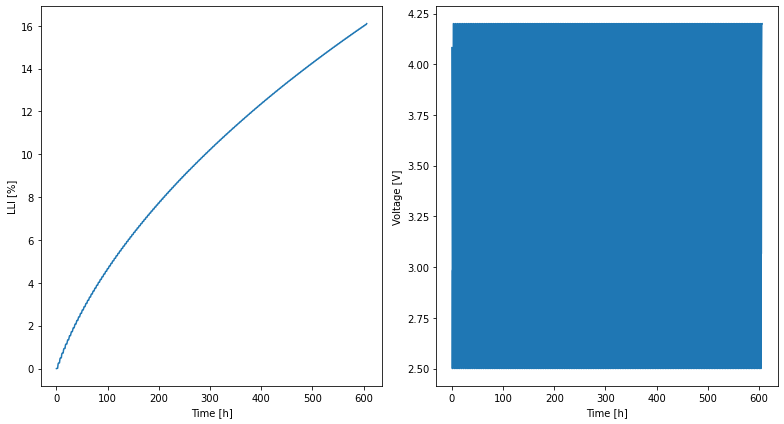

In [81]:
fig, ax = plt.subplots(1,2,figsize=(11,6))

ax[0].plot(spm_sol_100["Time [h]"].data, spm_sol_100["Loss of Lithium Inventory [%]"].data)
ax[0].set_xlabel("Time [h]")
ax[0].set_ylabel("LLI [%]")
ax[1].plot(spm_sol_100["Time [h]"].data, spm_sol_100["Terminal voltage [V]"].data)
ax[1].set_xlabel("Time [h]")
ax[1].set_ylabel("Voltage [V]")

fig.tight_layout()
OUTPUT_DIR = "/Users/vsulzer/Google Drive/PCL_Sulzer/"
fig.savefig(OUTPUT_DIR + "100_cycles.eps", dpi=1000)

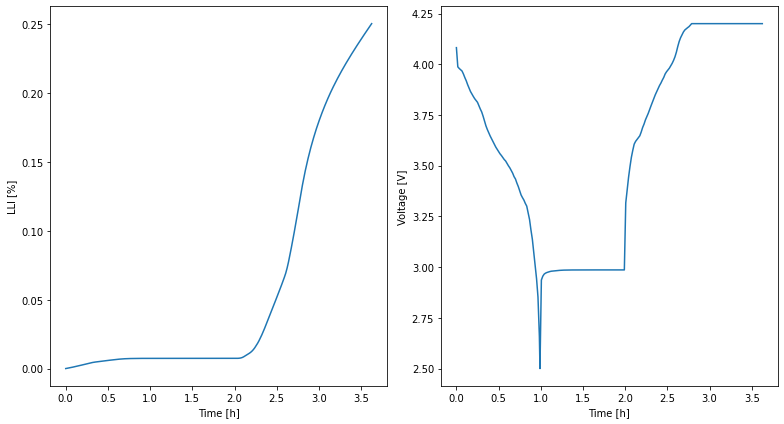

In [82]:
fig, ax = plt.subplots(1,2,figsize=(11,6))

ax[0].plot(spm_sol_100.cycles[0]["Time [h]"].data, spm_sol_100.cycles[0]["Loss of Lithium Inventory [%]"].data)
ax[0].set_xlabel("Time [h]")
ax[0].set_ylabel("LLI [%]")
ax[1].plot(spm_sol_100.cycles[0]["Time [h]"].data, spm_sol_100.cycles[0]["Terminal voltage [V]"].data)
ax[1].set_xlabel("Time [h]")
ax[1].set_ylabel("Voltage [V]")

fig.tight_layout()
fig.savefig(OUTPUT_DIR + "first_cycle.eps", dpi=1000)

In [128]:
lli_100 = spm_sol_800["Loss of Lithium Inventory [%]"].data
lli_100_cycles = lli_100[-1] - lli_100[0]

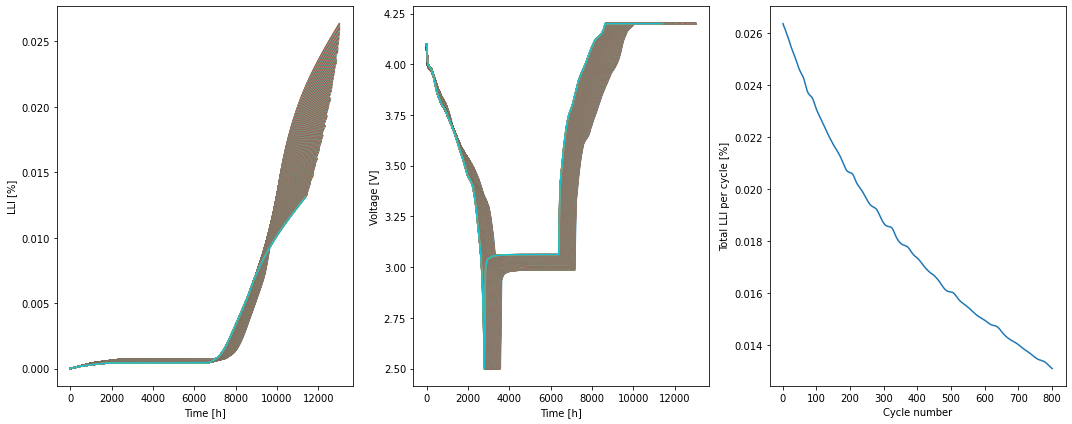

In [129]:

fig, ax = plt.subplots(1,3,figsize=(15,6))

all_lli = []
for cycle in spm_sol_800.cycles:
    t = cycle["Time [s]"].data
    lli = cycle["Loss of Lithium Inventory [%]"].data
    V = cycle["Terminal voltage [V]"].data

    ax[0].plot(t - t[0], lli-lli[0])
    ax[1].plot(t-t[0], V)
    
    all_lli.append(lli[-1]-lli[0])

ax[0].set_xlabel("Time [h]")
ax[0].set_ylabel("LLI [%]")    
ax[1].set_xlabel("Time [h]")
ax[1].set_ylabel("Voltage [V]")

ax[2].plot(range(1, len(all_lli)+1), all_lli)
ax[2].set_xlabel("Cycle number")
ax[2].set_ylabel("Total LLI per cycle [%]")

fig.tight_layout()
fig.savefig(OUTPUT_DIR + "cycles_comparison.eps", dpi=1000)

### eSOH parameters


In [85]:
len(spm_sol_100.summary_variables.items())

71

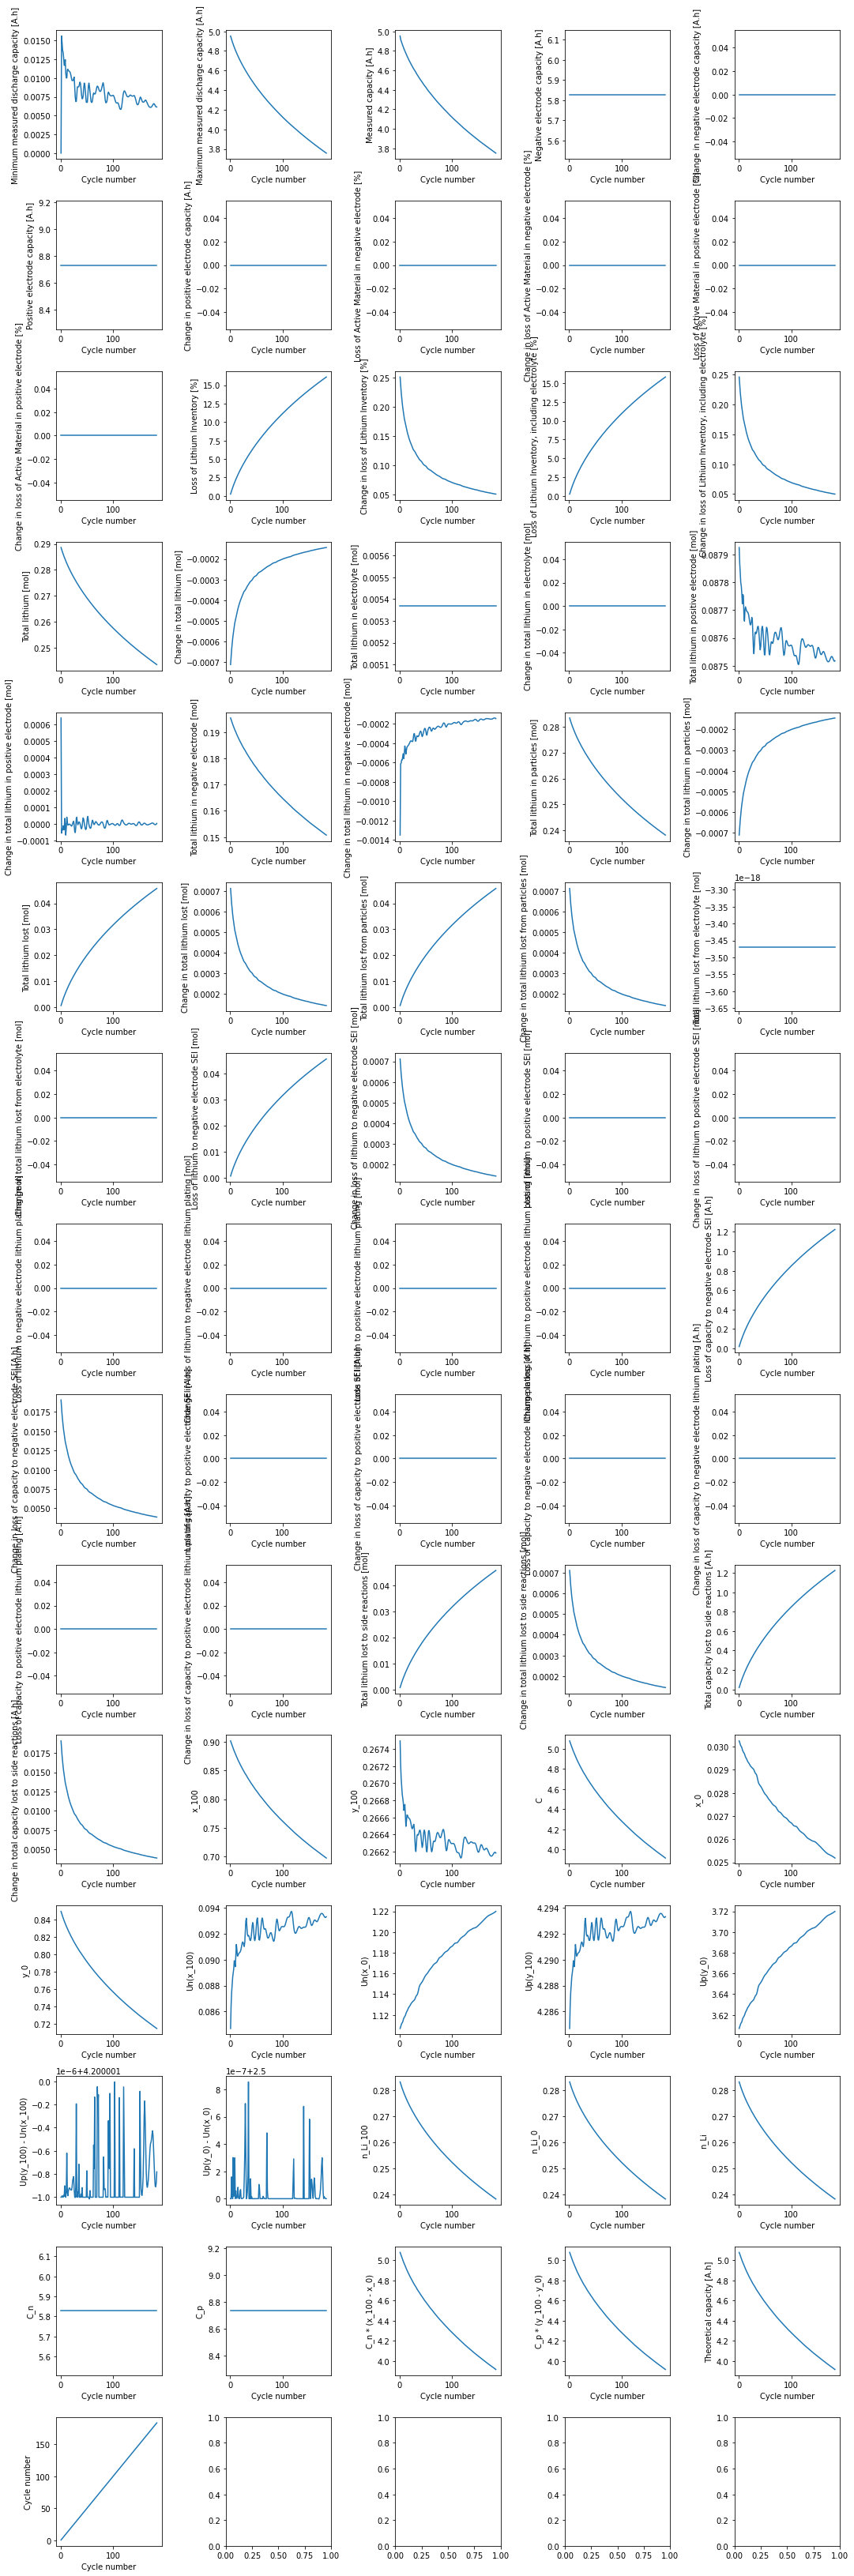

In [86]:
fig, axes = plt.subplots(15,5,figsize=(15,45))

for k, (name,val) in enumerate(spm_sol_100.summary_variables.items()):
    ax = axes.flat[k]
    ax.plot(spm_sol_100.summary_variables["Cycle number"],val)
    ax.set_xlabel("Cycle number")
    ax.set_ylabel(name)

# axes.flat[4].plot(range(1,101), all_nLi)
# axes.flat[4].set_xlabel("Cycle number")
# axes.flat[4].set_ylabel("n_Li")
# axes.flat[-1].plot(range(1,101), all_C)
# axes.flat[-1].set_xlabel("Cycle number")
# axes.flat[-1].set_ylabel("C")
# axes.flat[-1].set_ylim([2,5])
# axes.flat[-2].set_ylim([2,5])

fig.tight_layout()

## Accelerated simulations algorithm

### Constant extrapolation

Solve for 1 cycle

In [87]:
experiment = pybamm.Experiment([
    (f"Discharge at 1C until {Vmin}V",
     "Rest for 1 hour",
     f"Charge at 1C until {Vmax}V", 
     f"Hold at {Vmax}V until C/50")
])
sim = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values)
spm_sol = sim.solve()

2021-03-02 16:51:29,588 - [NOTICE] simulation.solve(693): Cycle 1/1 (24.466 ms elapsed) --------------------
2021-03-02 16:51:29,589 - [NOTICE] simulation.solve(723): Cycle 1/1, step 1/4: Discharge at 1C until 2.5V
2021-03-02 16:51:29,793 - [NOTICE] simulation.solve(723): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-02 16:51:29,959 - [NOTICE] simulation.solve(723): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-02 16:51:30,140 - [NOTICE] simulation.solve(723): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-03-02 16:51:30,522 - [NOTICE] simulation.solve(784): Finish experiment simulation, took 957.653 ms


Check how well extrapolating 1 cycle does

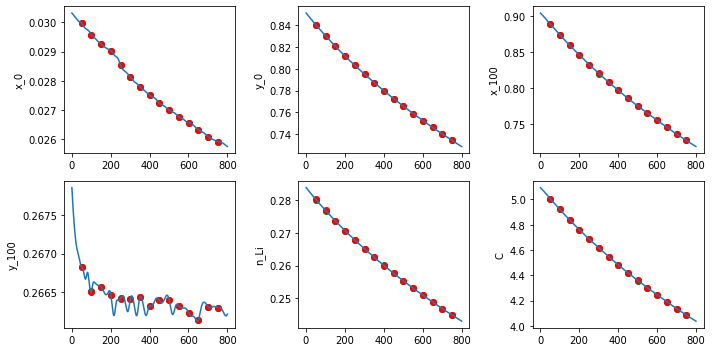

In [124]:
n_cycles_step = 50
long_sol = spm_sol_800
cycle = 0

esoh_vars = ["x_0", "y_0", "x_100", "y_100", "n_Li", "C"]

fig, ax = plt.subplots(2,3,figsize=(10,5))
for k, name in enumerate(esoh_vars):
    ax.flat[k].plot(long_sol.summary_variables["Cycle number"], long_sol.summary_variables[name])
    ax.flat[k].set_ylabel(name)

while cycle < len(long_sol.cycles)-n_cycles_step:
    n_Li_cycle = long_sol.cycles[cycle]["Total lithium in particles [mol]"].data
    n_Li_cycle_init = n_Li_cycle[0]
    delta_nLi_cycle = n_Li_cycle[0] - n_Li_cycle[-1]
    
    n_Li = n_Li_cycle_init - delta_nLi_cycle * n_cycles_step

    esoh_sol = esoh_sim.solve(
        [0],
        inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li},
    )
    esoh_sim.built_model.set_initial_conditions_from(esoh_sol)
    
    cycle += n_cycles_step
    for k, name in enumerate(esoh_vars):
        ax.flat[k].scatter(cycle+1,esoh_sol[name].data[0],color="g")
        ax.flat[k].scatter(cycle+1,long_sol.summary_variables[name][cycle],color="r")
        
fig.tight_layout()

Use extrapolation to initialize next simulation

In [125]:
experiment = pybamm.Experiment([
    (f"Discharge at 1C until {Vmin}V",
     "Rest for 1 hour",
     f"Charge at 1C until {Vmax}V", 
     f"Hold at {Vmax}V until C/50")
])

sim_acc = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values)
sol_acc = []
cycle_nums = []
cycle = 0
while cycle < len(long_sol.cycles):
    print(cycle)
    # Simulate one cycle
    sol = sim_acc.solve()
    
    n_Li_cycle = sol["Total lithium in particles [mol]"].data
    n_Li_cycle_init = n_Li_cycle[0]
    delta_nLi_cycle = n_Li_cycle[0] - n_Li_cycle[-1]
    
    n_Li = n_Li_cycle_init - delta_nLi_cycle * n_cycles_step

    esoh_sol = esoh_sim.solve(
        [0],
        inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li},
    )
    esoh_sim.built_model.set_initial_conditions_from(esoh_sol)
    ics = {}
    x_100 = esoh_sol["x_100"].data[0]
    y_100 = esoh_sol["y_100"].data[0]
    for var in sol.all_models[0].initial_conditions:
        if var.name == "X-averaged negative particle concentration":
            ics[var.name] = x_100 * np.ones((sol.all_models[0].variables[var.name].size, 2))
        elif var.name == "X-averaged positive particle concentration":
            ics[var.name] = y_100 * np.ones((sol.all_models[0].variables[var.name].size, 2))
        else:
            ics[var.name] = sim_acc.solution[var.name].data
    sim_acc.op_conds_to_built_models[experiment.operating_conditions[0][:2]].set_initial_conditions_from(ics)

    cycle_nums.append(cycle)
    sol_acc.append(sol)
    cycle += n_cycles_step
        
fig.tight_layout()

0


2021-03-02 17:32:51,982 - [NOTICE] simulation.solve(693): Cycle 1/1 (23.253 ms elapsed) --------------------
2021-03-02 17:32:51,983 - [NOTICE] simulation.solve(723): Cycle 1/1, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:32:52,182 - [NOTICE] simulation.solve(723): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-02 17:32:52,346 - [NOTICE] simulation.solve(723): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:32:52,525 - [NOTICE] simulation.solve(723): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:32:52,937 - [NOTICE] simulation.solve(784): Finish experiment simulation, took 978.050 ms
2021-03-02 17:32:53,001 - [NOTICE] simulation.solve(693): Cycle 1/1 (27.034 ms elapsed) --------------------
2021-03-02 17:32:53,002 - [NOTICE] simulation.solve(723): Cycle 1/1, step 1/4: Discharge at 1C until 2.5V


50


2021-03-02 17:32:53,215 - [NOTICE] simulation.solve(723): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-02 17:32:53,423 - [NOTICE] simulation.solve(723): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:32:53,582 - [NOTICE] simulation.solve(723): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:32:53,925 - [NOTICE] simulation.solve(784): Finish experiment simulation, took 951.593 ms
2021-03-02 17:32:53,980 - [NOTICE] simulation.solve(693): Cycle 1/1 (26.080 ms elapsed) --------------------
2021-03-02 17:32:53,980 - [NOTICE] simulation.solve(723): Cycle 1/1, step 1/4: Discharge at 1C until 2.5V


100


2021-03-02 17:32:54,187 - [NOTICE] simulation.solve(723): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-02 17:32:54,352 - [NOTICE] simulation.solve(723): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:32:54,490 - [NOTICE] simulation.solve(723): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:32:54,816 - [NOTICE] simulation.solve(784): Finish experiment simulation, took 862.191 ms
2021-03-02 17:32:54,873 - [NOTICE] simulation.solve(693): Cycle 1/1 (27.230 ms elapsed) --------------------
2021-03-02 17:32:54,874 - [NOTICE] simulation.solve(723): Cycle 1/1, step 1/4: Discharge at 1C until 2.5V


150


2021-03-02 17:32:55,074 - [NOTICE] simulation.solve(723): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-02 17:32:55,247 - [NOTICE] simulation.solve(723): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:32:55,383 - [NOTICE] simulation.solve(723): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:32:55,718 - [NOTICE] simulation.solve(784): Finish experiment simulation, took 871.992 ms
2021-03-02 17:32:55,777 - [NOTICE] simulation.solve(693): Cycle 1/1 (29.741 ms elapsed) --------------------
2021-03-02 17:32:55,777 - [NOTICE] simulation.solve(723): Cycle 1/1, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:32:55,959 - [NOTICE] simulation.solve(723): Cycle 1/1, step 2/4: Rest for 1 hour


200


2021-03-02 17:32:56,131 - [NOTICE] simulation.solve(723): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:32:56,300 - [NOTICE] simulation.solve(723): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:32:56,687 - [NOTICE] simulation.solve(784): Finish experiment simulation, took 940.129 ms
2021-03-02 17:32:56,742 - [NOTICE] simulation.solve(693): Cycle 1/1 (26.006 ms elapsed) --------------------
2021-03-02 17:32:56,742 - [NOTICE] simulation.solve(723): Cycle 1/1, step 1/4: Discharge at 1C until 2.5V


250


2021-03-02 17:32:56,947 - [NOTICE] simulation.solve(723): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-02 17:32:57,131 - [NOTICE] simulation.solve(723): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:32:57,285 - [NOTICE] simulation.solve(723): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:32:57,649 - [NOTICE] simulation.solve(784): Finish experiment simulation, took 932.872 ms
2021-03-02 17:32:57,713 - [NOTICE] simulation.solve(693): Cycle 1/1 (31.433 ms elapsed) --------------------
2021-03-02 17:32:57,713 - [NOTICE] simulation.solve(723): Cycle 1/1, step 1/4: Discharge at 1C until 2.5V


300


2021-03-02 17:32:57,909 - [NOTICE] simulation.solve(723): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-02 17:32:58,080 - [NOTICE] simulation.solve(723): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:32:58,216 - [NOTICE] simulation.solve(723): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:32:58,543 - [NOTICE] simulation.solve(784): Finish experiment simulation, took 861.921 ms
2021-03-02 17:32:58,605 - [NOTICE] simulation.solve(693): Cycle 1/1 (30.567 ms elapsed) --------------------
2021-03-02 17:32:58,605 - [NOTICE] simulation.solve(723): Cycle 1/1, step 1/4: Discharge at 1C until 2.5V


350


2021-03-02 17:32:58,818 - [NOTICE] simulation.solve(723): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-02 17:32:58,987 - [NOTICE] simulation.solve(723): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:32:59,107 - [NOTICE] simulation.solve(723): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:32:59,482 - [NOTICE] simulation.solve(784): Finish experiment simulation, took 908.206 ms
2021-03-02 17:32:59,550 - [NOTICE] simulation.solve(693): Cycle 1/1 (29.437 ms elapsed) --------------------
2021-03-02 17:32:59,550 - [NOTICE] simulation.solve(723): Cycle 1/1, step 1/4: Discharge at 1C until 2.5V


400


2021-03-02 17:32:59,736 - [NOTICE] simulation.solve(723): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-02 17:32:59,915 - [NOTICE] simulation.solve(723): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:33:00,048 - [NOTICE] simulation.solve(723): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:33:00,361 - [NOTICE] simulation.solve(784): Finish experiment simulation, took 840.572 ms
2021-03-02 17:33:00,423 - [NOTICE] simulation.solve(693): Cycle 1/1 (31.347 ms elapsed) --------------------
2021-03-02 17:33:00,424 - [NOTICE] simulation.solve(723): Cycle 1/1, step 1/4: Discharge at 1C until 2.5V


450


2021-03-02 17:33:00,613 - [NOTICE] simulation.solve(723): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-02 17:33:00,788 - [NOTICE] simulation.solve(723): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:33:00,925 - [NOTICE] simulation.solve(723): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:33:01,256 - [NOTICE] simulation.solve(784): Finish experiment simulation, took 863.622 ms
2021-03-02 17:33:01,312 - [NOTICE] simulation.solve(693): Cycle 1/1 (27.728 ms elapsed) --------------------
2021-03-02 17:33:01,312 - [NOTICE] simulation.solve(723): Cycle 1/1, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:33:01,491 - [NOTICE] simulation.solve(723): Cycle 1/1, step 2/4: Rest for 1 hour


500


2021-03-02 17:33:01,644 - [NOTICE] simulation.solve(723): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:33:01,780 - [NOTICE] simulation.solve(723): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:33:02,131 - [NOTICE] simulation.solve(784): Finish experiment simulation, took 846.954 ms
2021-03-02 17:33:02,195 - [NOTICE] simulation.solve(693): Cycle 1/1 (30.584 ms elapsed) --------------------
2021-03-02 17:33:02,195 - [NOTICE] simulation.solve(723): Cycle 1/1, step 1/4: Discharge at 1C until 2.5V


550


2021-03-02 17:33:02,380 - [NOTICE] simulation.solve(723): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-02 17:33:02,565 - [NOTICE] simulation.solve(723): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:33:02,708 - [NOTICE] simulation.solve(723): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:33:03,053 - [NOTICE] simulation.solve(784): Finish experiment simulation, took 888.636 ms
2021-03-02 17:33:03,109 - [NOTICE] simulation.solve(693): Cycle 1/1 (28.876 ms elapsed) --------------------
2021-03-02 17:33:03,109 - [NOTICE] simulation.solve(723): Cycle 1/1, step 1/4: Discharge at 1C until 2.5V


600


2021-03-02 17:33:03,298 - [NOTICE] simulation.solve(723): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-02 17:33:03,468 - [NOTICE] simulation.solve(723): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:33:03,592 - [NOTICE] simulation.solve(723): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:33:03,906 - [NOTICE] simulation.solve(784): Finish experiment simulation, took 826.236 ms
2021-03-02 17:33:03,957 - [NOTICE] simulation.solve(693): Cycle 1/1 (24.400 ms elapsed) --------------------
2021-03-02 17:33:03,958 - [NOTICE] simulation.solve(723): Cycle 1/1, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:33:04,107 - [NOTICE] simulation.solve(723): Cycle 1/1, step 2/4: Rest for 1 hour


650


2021-03-02 17:33:04,284 - [NOTICE] simulation.solve(723): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:33:04,406 - [NOTICE] simulation.solve(723): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:33:04,728 - [NOTICE] simulation.solve(784): Finish experiment simulation, took 795.297 ms
2021-03-02 17:33:04,778 - [NOTICE] simulation.solve(693): Cycle 1/1 (23.961 ms elapsed) --------------------
2021-03-02 17:33:04,779 - [NOTICE] simulation.solve(723): Cycle 1/1, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:33:04,934 - [NOTICE] simulation.solve(723): Cycle 1/1, step 2/4: Rest for 1 hour


700


2021-03-02 17:33:05,098 - [NOTICE] simulation.solve(723): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:33:05,230 - [NOTICE] simulation.solve(723): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:33:05,574 - [NOTICE] simulation.solve(784): Finish experiment simulation, took 819.838 ms
2021-03-02 17:33:05,632 - [NOTICE] simulation.solve(693): Cycle 1/1 (27.191 ms elapsed) --------------------
2021-03-02 17:33:05,633 - [NOTICE] simulation.solve(723): Cycle 1/1, step 1/4: Discharge at 1C until 2.5V
2021-03-02 17:33:05,811 - [NOTICE] simulation.solve(723): Cycle 1/1, step 2/4: Rest for 1 hour


750


2021-03-02 17:33:05,980 - [NOTICE] simulation.solve(723): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-02 17:33:06,096 - [NOTICE] simulation.solve(723): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-03-02 17:33:06,440 - [NOTICE] simulation.solve(784): Finish experiment simulation, took 835.120 ms


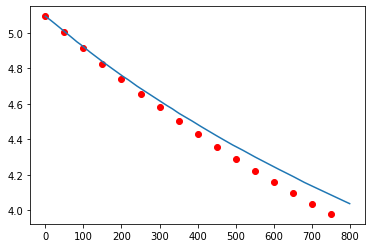

In [126]:
n_Li_acc = [sol.summary_variables["C"] for sol in sol_acc]

fig, ax = plt.subplots()
ax.plot(cycle_nums, n_Li_acc, "ro")
ax.plot(long_sol.summary_variables["C"])
# for k, sol in enumerate(sol_acc):
#     print(sol.summary_variables["n_Li"])
#     print(spm_sol_100.summary_variables["n_Li"][k * n_cycles_step])

2021-03-02 17:33:15,103 - [WARNING] backend_ps._is_transparent(734): The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2021-03-02 17:33:15,103 - [WARNING] backend_ps._is_transparent(734): The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


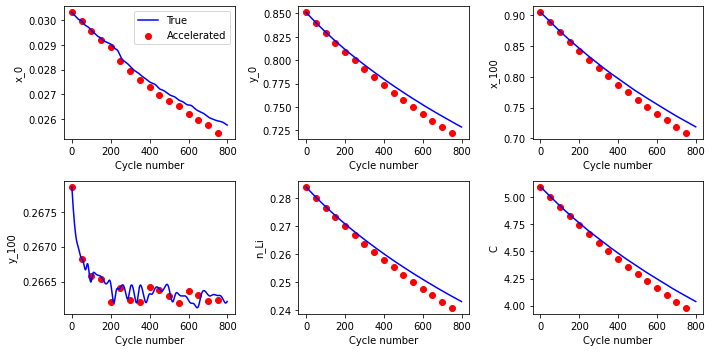

In [127]:
n_Li_acc = [sol.summary_variables["C"] for sol in sol_acc]
esoh_vars = ["x_0", "y_0", "x_100", "y_100", "n_Li", "C"]

fig, axes = plt.subplots(2,3,figsize=(10,5))
for k, name in enumerate(esoh_vars):
    ax = axes.flat[k]
    ax.scatter(cycle_nums,[sol.summary_variables[name] for sol in sol_acc],color="r")
    ax.plot(long_sol.summary_variables[name],"b-")
    ax.set_ylabel(name)
    ax.set_xlabel("Cycle number")
    
axes.flat[0].legend(["True", "Accelerated"])
fig.tight_layout()
fig.savefig(OUTPUT_DIR + "accelerated_sims.eps", dpi=1000)